# 인물사진을 만들어보자

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

(1960, 4032, 3)


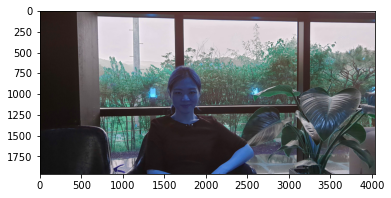

In [99]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
img_orig = increase_brightness(img_orig, value=5)
plt.imshow(img_orig)
print (img_orig.shape)

In [100]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

- Segmentation에는 FCN, SegNet, U-Net 등 많은 모델이 사용됨.
- DeepLab v3+은 segmentation model 중 성능이 좋아 최근에도 많이 사용됨.
- [참고링크](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)
- DeepLab에서는 atroud convolution을 사용했는데, parameter 수를 늘리지 않고도 receptive field를 크게 키울 수 있기 때문.
- Depthwise separable convolution은 Xception에서 처음 사용되었고, 3x3 conv layer의 receptive field를 1/9 수준의 파라미터로 구현할 수 있으므로 효율적
- [사용모델](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [101]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [102]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [103]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1960, 4032, 3) (249, 513, 3) 15


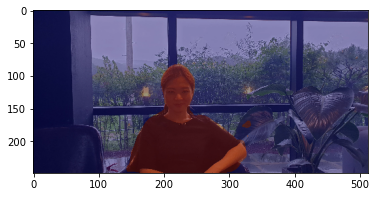

In [105]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [106]:
np.unique(color_mask)

array([  0, 128], dtype=uint8)

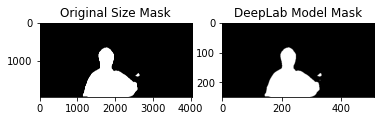

In [107]:
# 좌표가 다른 것을 확인할 수 있음.
# 더 정확히 확대하기 위해서 cv2.Inter_NEAREST 사용.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

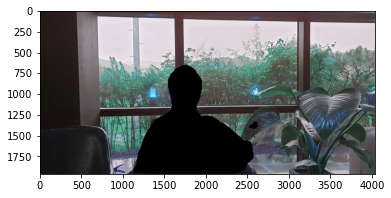

In [108]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

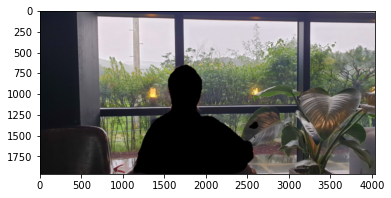

In [109]:
img_bg_blur = cv2.blur(img_bg, (10,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

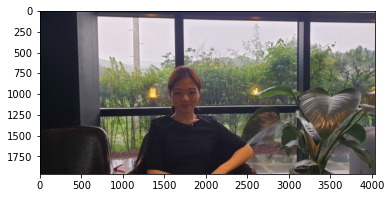

In [110]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [134]:
def background_blur(path,blur,label):
    # path에서 이미지 불러오기
    img_orig_ = cv2.imread(path)
    # 모델 적용하기
    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

    model_dir_ = '~/aiffel/human_segmentation/models'
    tf.io.gfile.makedirs(model_dir_)

    download_path_ = os.path.join(model_dir_, 'deeplab_model.tar.gz')
    if not os.path.exists(download_path_):
        urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                       download_path_)
    MODEL = DeepLabModel(download_path_)
    img_resized_, seg_map_ = MODEL.run(img_orig_)
    print (img_orig_.shape, img_resized_.shape, seg_map_.max())
    
    img_show_ = img_resized_.copy()
    # 예측 중 사람만 추출
    seg_map_ = np.where(seg_map_ == label, label, 0) 
    img_mask_ = seg_map_ * (255/seg_map_.max()) # 255 normalization
    img_mask_ = img_mask_.astype(np.uint8)
    color_mask_ = cv2.applyColorMap(img_mask_, cv2.COLORMAP_JET)
    img_show_ = cv2.addWeighted(img_show_, 0.6, color_mask_, 0.35, 0.0)
    
    img_mask_up_ = cv2.resize(img_mask_, img_orig_.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up_ = cv2.threshold(img_mask_up_, 128, 255, cv2.THRESH_BINARY)

    img_mask_color_ = cv2.cvtColor(img_mask_up_, cv2.COLOR_GRAY2BGR)
    img_bg_mask_ = cv2.bitwise_not(img_mask_color_)
    img_bg_ = cv2.bitwise_and(img_orig_, img_bg_mask_)
    
    img_bg_blur_ = cv2.blur(img_bg_, blur)
    
    img_concat_ = np.where(img_mask_color_==255, img_orig_, img_bg_blur_)
    return plt.imshow(cv2.cvtColor(img_concat_, cv2.COLOR_BGR2RGB))

(1960, 4032, 3) (249, 513, 3) 15


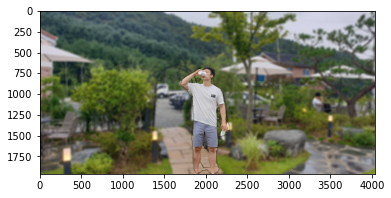

In [139]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg'
background_blur(img_path2,(30,30),15)

(3024, 3024, 3) (513, 513, 3) 15


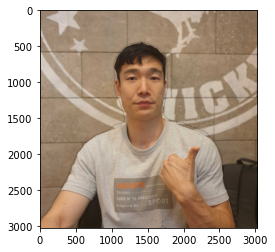

In [140]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'
background_blur(img_path2,(20,20),15)

(564, 480, 3) (513, 436, 3) 8


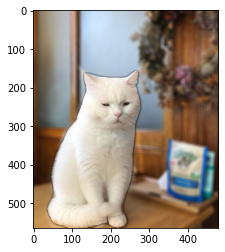

In [142]:
# 보면 고양이를 인식 못하고 있음을 확인할 수 있다.
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
background_blur(img_path2,(10,10),8)

In [127]:
# 배경 바꿔보기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_back = cv2.imread(img_path) 
print (img_orig_back.shape)

(1960, 4032, 3)


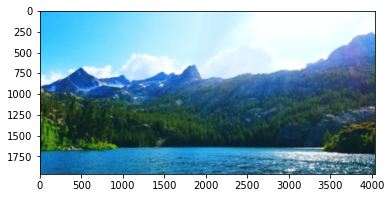

In [112]:
img_bg_blur = cv2.blur(img_orig_back, (15,15))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

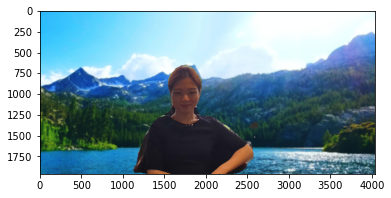

In [113]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 한계점
- 윗 사진만 봐도 블러를 좀 심하게 하면 피사체와 부자연스럽게 분리되는 것을 볼 수 있다.
- 나뭇잎의 일부를 피사체와 동일한 것으로 잘못 인식하고, 다른 사진은 다리 사이의 물체를 다른 사물이라고 인식못하여 부자연 스럽게 나옴.
- 이 부분을 어떻게 해결? => 경계를 어떻게 처리해야할지 고민이 필요할 것 같다. 